In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

C:\Users\Szymon\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Poems Generator

In [2]:
tokenizer = Tokenizer()

data = open('poems.txt', encoding='utf8').read()
corpus = data.lower().split('\n')
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [3]:
len(corpus)

740

In [4]:
tokenizer.word_index

{'i': 1,
 'sie': 2,
 'na': 3,
 'w': 4,
 'z': 5,
 'to': 6,
 'a': 7,
 'jak': 8,
 'nie': 9,
 'do': 10,
 'niy': 11,
 'bo': 12,
 'po': 13,
 'że': 14,
 'se': 15,
 'co': 16,
 'boja': 17,
 'we': 18,
 'za': 19,
 '–': 20,
 'ze': 21,
 'już': 22,
 'mu': 23,
 'tak': 24,
 'mioł': 25,
 'je': 26,
 'mo': 27,
 'nic': 28,
 'te': 29,
 'choć': 30,
 'tam': 31,
 'łod': 32,
 'się': 33,
 'bydzie': 34,
 'tego': 35,
 'bez': 36,
 'jeszcze': 37,
 'tyż': 38,
 'potym': 39,
 'nos': 40,
 'my': 41,
 'czy': 42,
 'kożdy': 43,
 'zaś': 44,
 'ni': 45,
 'som': 46,
 'go': 47,
 'jest': 48,
 'u': 49,
 'dom': 50,
 'ło': 51,
 'pod': 52,
 'tyn': 53,
 'kaj': 54,
 'kery': 55,
 'szkole': 56,
 'nom': 57,
 'przeca': 58,
 'ci': 59,
 'cie': 60,
 'nich': 61,
 'mie': 62,
 'przi': 63,
 'by': 64,
 'hanysy': 65,
 'ino': 66,
 'mi': 67,
 'ślonsku': 68,
 'byda': 69,
 'fest': 70,
 'tym': 71,
 'tu': 72,
 'ale': 73,
 'ludzie': 74,
 'o': 75,
 'jo': 76,
 'kto': 77,
 'bezto': 78,
 'juz': 79,
 'yno': 80,
 'paulek': 81,
 'gustlik': 82,
 'ani': 83,
 'tyj

In [5]:
total_words

2032

In [147]:
def generate_dataset(corpus):
	input_sequences = []
	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]
		for i in range(1, len(token_list)):
			n_gram_sequence = token_list[:i+1]
			input_sequences.append(n_gram_sequence)

	# pad sequences 
	max_sequence_len = max([len(x) for x in input_sequences])
	input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

	# create predictors and label
	xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
	ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

	return xs, ys, max_sequence_len

xs, ys, max_sequence_len = generate_dataset(corpus)

In [7]:
len(xs)

3493

In [145]:
def get_model(max_sequence_len, compile=True):
    model = Sequential()
    model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    # model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))
    if compile:
        adam = Adam(lr=0.01)
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystoping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='checkpoints/poem_generator', save_weights_only=True)

In [10]:
poem_model = get_model(max_sequence_len)
poem_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 128)           260096    
                                                                 
 bidirectional (Bidirectiona  (None, 10, 300)          334800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2032)              611632    
                                                                 
Total params: 1,747,728
Trainable params: 1,747,728
Non-trainable params: 0
_________________________________________________________________


C:\Users\Szymon\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = poem_model.fit(xs, ys, epochs=80, callbacks=[earlystoping, checkpoint])

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

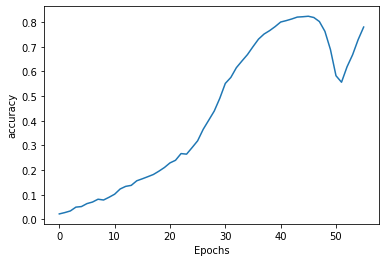

In [13]:
plot_graphs(history, 'accuracy')

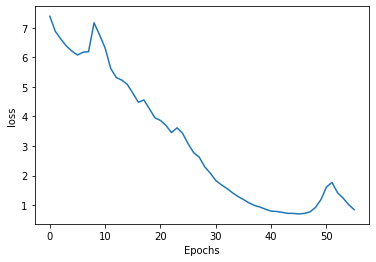

In [14]:
plot_graphs(history, 'loss')

In [15]:
def word_from_token(tokenizer, token):
	for word, index in tokenizer.word_index.items():
		if index == token:
			return word

word_from_token(tokenizer, 34)

'bydzie'

In [16]:
seed_text = "A kej pojemy i pośpiywomy,"
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

In [17]:
predicted = poem_model.predict(token_list)[0]
pred_words = sorted(range(len(predicted)), key=lambda k: predicted[k], reverse=True)[:10]
pred_words

1/1 [==============================] - 2s 2s/step


[1251, 170, 44, 1634, 1664, 1481, 1250, 1455, 1650, 6]

In [18]:
predicted = poem_model.predict(token_list)[0]
print(np.argmax(predicted, axis=-1))
word_from_token(tokenizer, np.argmax(predicted, axis=-1))

1/1 [==============================] - 0s 33ms/step
1251


'dolary'

In [19]:
from tensorflow.nn import softmax
import numpy as np

In [20]:
input_vec = np.array([0.9351494, 0.01913008, 0.012285918, 0.0073973653, 0.0045387684, 0.0030624913, 0.001663432, 0.0015019202, 0.0012784688, 0.0010290503])
temp = 1
out = np.array(softmax(input_vec * temp))
print(out)
np.sum(out)

[0.21962419 0.08787352 0.08727416 0.08684855 0.08660064 0.08647289
 0.086352   0.08633805 0.08631876 0.08629723]


1.0

In [71]:
def predict_word(model, tokenizer, token_list, temp=1, size=10):
    predicted = model.predict(token_list, verbose=0)[0]
    pred_tokens = sorted(range(len(predicted)), key=lambda k: predicted[k], reverse=True)[:size]
    probabilities = np.array(sorted(predicted, reverse=True)[:size])

    probabilities = np.around(softmax(probabilities),2)
    probabilities /= np.sum(probabilities)

    draw = np.random.choice(pred_tokens, 1, True, probabilities)
    return word_from_token(tokenizer, draw)

predict_word(poem_model, tokenizer, token_list)

'dwóch'

In [72]:
seed_text = "A kej pojemy i pośpiywomy,"
next_words = 60
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = predict_word(poem_model, tokenizer, token_list)
	seed_text += " " + output_word
print(seed_text)

A kej pojemy i pośpiywomy, ich szukoł dolary we dwóch na chroboki… sie martwiymy szpajzy podlola wcale do klopsztanga je we se już już z krzidełkami przysiadła piere za dwóch na cie krziwo na wgramoli sie w piere glajzach w glajzach dali sie z rana nic nie trzeba we posłów już było już dopiyro jest do kwietnio już chyba niy w w zagloskać co już


## Feuilleton Generator

In [80]:
import re

In [142]:
tokenizer = Tokenizer(oov_token='\n')

data = open('raw_feuilletons.txt', encoding='utf8').read()
data = data.replace('. ', '\n')
corpus = np.array(data.lower().split('\n'))
corpus = corpus[corpus != '']
corpus = [c+' \n' for c in corpus]

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [143]:
corpus

['coś poszło niy tak, jeźli ślōnski starzik kojarzi nōm sie ino ze sużbom we wermachcie \n',
 'chociŏż wojynne przigody naszych starzikōw były pewnikym tymatym niyjednyj ôzprŏwki przi kafyju abo szolce kakao \n',
 'przeca kożdy ynkelek chcioł wiedzieć wiyncyj ô wojynnych historyjach szadego już starzika… \n',
 'dzisiyjsi starziki niy pamiyntajōm już wojaczki, bo pewnikym sōm potōmnymi tych, kerzi walczyli na europejskich frōntach \n',
 'niy ôznaczŏ to jednak, iże jejich historyje sōm mynij ciekawe abo interesujōnce \n',
 'robota w srogim werku industryjalnym, raje do sklepōw, prōżne pōłki we sklepach, urlaub niy w grecyji, ale nad polskim morzym – to ryalność prlu, kerŏ dlŏ terŏźnych modych brzmiōm jak bojka \n',
 'jeźli mōgbych wrōcić sie 15 lŏt nazŏd to dołbych sie jedna dorada – suchej swojigo starzika, bo je ôn skarbnicōm wiedzy i historyji. \n',
 'dziynki mojimu starzikowi zakochołech sie w gōrach \n',
 'kej miołch pŏranŏście lŏt broł mie na rajzy w beskid ślōnski \n',
 'ôwdy jesz

In [144]:
tokenizer.word_index['\n']

1

In [133]:
with open('feuilletons.txt', 'w', encoding='utf-8') as f:
    for c in corpus:
        f.write(c)
        f.write('\n')

In [134]:
total_words

976

In [148]:
xs, ys, max_sequence_len = generate_dataset(corpus)

In [149]:
earlystoping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='checkpoints/feulliton_generator', save_weights_only=True)

In [150]:
feulliton_model = get_model(max_sequence_len)
feulliton_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 36, 128)           124928    
                                                                 
 bidirectional_4 (Bidirectio  (None, 36, 300)          334800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 976)               293776    
                                                                 
Total params: 1,294,704
Trainable params: 1,294,704
Non-trainable params: 0
_________________________________________________________________


C:\Users\Szymon\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [151]:
history = feulliton_model.fit(xs, ys, epochs=80, callbacks=[earlystoping, checkpoint])

Epoch 1/80
57/57 [==============================] - 29s 356ms/step - loss: 6.8214 - accuracy: 0.0181
Epoch 2/80
57/57 [==============================] - 18s 312ms/step - loss: 6.3159 - accuracy: 0.0312
Epoch 3/80
57/57 [==============================] - 19s 333ms/step - loss: 6.2030 - accuracy: 0.0269
Epoch 4/80
57/57 [==============================] - 18s 317ms/step - loss: 6.2014 - accuracy: 0.0208
Epoch 5/80
57/57 [==============================] - 18s 323ms/step - loss: 6.1187 - accuracy: 0.0274
Epoch 6/80
57/57 [==============================] - 18s 316ms/step - loss: 6.0208 - accuracy: 0.0312
Epoch 7/80
57/57 [==============================] - 18s 315ms/step - loss: 6.0986 - accuracy: 0.0263
Epoch 8/80
57/57 [==============================] - 18s 318ms/step - loss: 6.0580 - accuracy: 0.0334
Epoch 9/80
57/57 [==============================] - 18s 311ms/step - loss: 5.7837 - accuracy: 0.0296
Epoch 10/80
57/57 [==============================] - 18s 317ms/step - loss: 5.6775 - accura

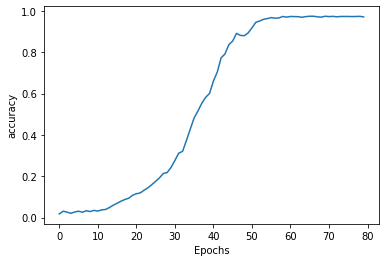

In [153]:
plot_graphs(history, 'accuracy')

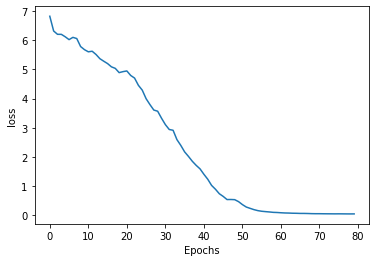

In [154]:
plot_graphs(history, 'loss')

In [157]:
seed_text = "widza i czuja, wiela mie to zdrowiŏ, prŏcy i wyrzeczyń kosztuje"
next_words = 60
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = predict_word(feulliton_model, tokenizer, token_list)
	seed_text += " " + output_word
print(seed_text)

widza i czuja, wiela mie to zdrowiŏ, prŏcy i wyrzeczyń kosztuje – ida ôd syniora regiōnalnyj na zŏlyty na kole durś świata raus górnych i bestōż fto sie kibel sie im bydzie otwierōł pogoda poszoł nazŏd na zolyty ô śpr tak za piastować jŏd kożdy wikynd jŏd starajōm terŏzki ludzi je ino starajōm sōm ale abo tak roztōmajte bo w gōry a ale aji jak śniŏdać niy bydōm nōm ô modości
